In [33]:
from sklearn.cluster import AffinityPropagation
import os
import re
import sys
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
import traceback
import numpy as np
import matplotlib.pyplot as plt
import string
import random
%matplotlib notebook

In [2]:
corpus_path = "/Users/zhouyou/Downloads/bbc news dataset"
all_path = "/Users/zhouyou/Downloads/summ/"
swr_path = "/Users/zhouyou/Downloads/swr_data/"

In [3]:
# load dataset
file_dirs = os.listdir(corpus_path)
# news dataset dir
corpus_text = []
for file_dir in file_dirs:
    if os.path.isdir(corpus_path + '/' + file_dir):
        # different category dir
        files = os.listdir(corpus_path + '/' + file_dir)
        count = 0
        for file in files:
            try:
                # 每种取了300篇
                if count < 300:
                    # txt file
                    f = open(corpus_path + '/' + file_dir + "/" + file)
                    text_content = ""
                    next(f)
                    for line in f.readlines():
                        if line != "\n":
                            text_content = text_content + line
                    text_content = text_content.replace("\n", "")
                    count = count + 1
                else:
                    break
                corpus_text.append(text_content)
            except:
                pass

In [4]:
# lemmatize
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


def lemmatize_sentence(sentence):
    res = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(word_tokenize(sentence)):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return res

In [5]:
# tokenize
tokenizer = RegexpTokenizer(r'\w+')

en_stop = get_stop_words('en')

p_stemmer = WordNetLemmatizer()

tokennized_text = []
tokennized_word = []

for i in corpus_text:
#     tokens = tokenizer.tokenize(i)
#     stopped_tokens = [i.lower() for i in tokens if not i in en_stop]
#     # stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
#     stemmed_tokens = [p_stemmer.lemmatize(i) for i in stopped_tokens]
    
    stemmed_tokens = lemmatize_sentence(i)
    
    for k in range(len(stemmed_tokens)):
        for letter in stemmed_tokens[k]:
            if letter in string.punctuation:
                stemmed_tokens[k] = stemmed_tokens[k].replace(letter, "")
                
    stop_words = set(stopwords.words('english'))        
    stemmed_tokens = [j.lower() for j in stemmed_tokens if j != '' and j not in stop_words]
    
    final_tokens = []
    for i in stemmed_tokens:
        if len(i) > 1:
            final_tokens.append(i)
    # print(stemmed_tokens)
    tokennized_word.extend(final_tokens)
    tokennized_text.append(final_tokens)



In [6]:
# 计算词频，删除频率太低的词
corpus_word_frequency = {}
for i in tokennized_word:
    if i in corpus_word_frequency:
        corpus_word_frequency[i] = corpus_word_frequency[i] + 1
    else:
        corpus_word_frequency.setdefault(i, 1)

In [7]:
low_frequency_word = []
for i in corpus_word_frequency.keys():
    if corpus_word_frequency[i] <= 2:
        low_frequency_word.append(i)

In [8]:
for i in tokennized_text:
    for j in low_frequency_word:
        if j in i:
            i.remove(j)

In [9]:
rebuild_text = []
for i in tokennized_text:
    temp = ""
    for word in i:
        temp = temp + " " + word
    rebuild_text.append(temp)

In [10]:
# 读文本
def readfile(path):
    # 遍历文件夹
    files = os.listdir(path)
    files.sort()
    for file in files:
        raw_text = ''
        raw_text_list = []
        if not os.path.isdir(file):
            # print("File name: " + file)
            f = open(path + "/" + file)
            for line in f.readlines():
                searchObj = re.findall(r'SNO=(.*?)>(.*?)</S>', line)
                if searchObj:
                    # print(searchObj)
                    # print(searchObj[0][0])
                    if searchObj[0][0] == "\"1\"":
                        raw_text = raw_text + searchObj[0][1] + '.' + ' '
                        raw_text_list.append(searchObj[0][1])
                    else:
                        raw_text = raw_text + searchObj[0][1] + ' '
                        raw_text_list.append(searchObj[0][1])
                    # print(s)
            yield file, raw_text, raw_text_list

In [11]:
def getDoc(document_path):
    per_raw_text = readfile(document_path)

    all_raw_text = []
    all_filenames = []
    all_raw_text_list = []

    for filename, raw_text, raw_text_list in per_raw_text:
        all_filenames.append(filename)
        all_raw_text.append(raw_text)
        all_raw_text_list.append(raw_text_list)

    # print(all_raw_text)
    # print(len(all_raw_text))

    tokenizer = RegexpTokenizer(r'\w+')

    en_stop = get_stop_words('en')
    
    stop_words = set(stopwords.words('english'))

    # p_stemmer = PorterStemmer()
    # p_stemmer = SnowballStemmer('english')

    # wordnet 提取词干效果更好
    p_stemmer = WordNetLemmatizer()


    doc = []
    for i in all_raw_text:
#         tokens = tokenizer.tokenize(i)
#         stopped_tokens = [i for i in tokens if not i in en_stop]
#         # stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
#         stemmed_tokens = [p_stemmer.lemmatize(i) for i in stopped_tokens]
        # print(stemmed_tokens)
        
        stemmed_tokens = lemmatize_sentence(i)
    
        for k in range(len(stemmed_tokens)):
            for letter in stemmed_tokens[k]:
                if letter in string.punctuation:
                    stemmed_tokens[k] = stemmed_tokens[k].replace(letter, "")
          
        stop_words = set(stopwords.words('english'))
        stemmed_tokens = [j.lower() for j in stemmed_tokens if j != '' and j not in stop_words]
        
        
        doc.append(stemmed_tokens)
        
    return doc, all_raw_text_list, all_filenames

In [25]:
def getSum(summary_path, filename, doc_select_list, dictionary, ldamodel):
#     doc_select_list = all_raw_text_list[0]
#     filename = all_filenames[0]
    searchObj = re.findall(r'-(.*)_', filename)
    extract_folder_name = searchObj[0][:-2]
    file = filename[2:-7]

    archive_files = os.listdir(summary_path)
    archive_files.sort()

    result = []
    summ_sent_count_list = []

    for archive_file in archive_files:
        path = summary_path + archive_file + "/extract/" + extract_folder_name
#         print(path)
        try:
            # print("File name: " + file)
            # print(path + "/" + file + "extract")
            f = open(path + "/" + file + "extract")
            summ = ''
            summ_sent_count = 0
            for line in f.readlines():
                # print(line)
                searchObj = re.findall(r'SNO="(.*)"', line)
                if searchObj:
                    summ = summ + (doc_select_list[int(searchObj[0]) - 1])
                    summ_sent_count = summ_sent_count + 1
            
            summ_sent_count_list.append(summ_sent_count)
                    
            tokenizer = RegexpTokenizer(r'\w+')

            en_stop = get_stop_words('en')

            p_stemmer = WordNetLemmatizer()

#             summ_tokens = tokenizer.tokenize(summ)
#             summ_stopped_tokens = [i for i in summ_tokens if not i in en_stop]
#             # stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
#             summ_stemmed_tokens = [p_stemmer.lemmatize(i) for i in summ_stopped_tokens]
            
            stemmed_tokens = lemmatize_sentence(summ)
    
            for k in range(len(stemmed_tokens)):
                for letter in stemmed_tokens[k]:
                    if letter in string.punctuation:
                        stemmed_tokens[k] = stemmed_tokens[k].replace(letter, "")
            
            stop_words = set(stopwords.words('english'))
            summ_stemmed_tokens = [j.lower() for j in stemmed_tokens if j != '' and j not in stop_words]

            
            
            summ_bow = dictionary.doc2bow(summ_stemmed_tokens)      
            res = ldamodel.get_document_topics(bow=summ_bow)

            result.append(res)

        except Exception as e:
#             print(e)
#             print(path + "/" + file + "extract")
#             traceback.print_exc()
            pass
        
    return result, summ_sent_count_list

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
def cal_cos_sim(temp, interval, document_topic_list, document_topic_porb):
    cos_sim = []
    count = 0
    for i in temp:
        if count%8 == interval:
            #     print(i)
            judge_topic_list = []
            for j in i:
                a, b = j
                judge_topic_list.append(a)
            union_set = set(document_topic_list).union(set(judge_topic_list))
    
            document_topic_porb_kv = {}
            for j in document_topic_porb:
                a, b = j
                document_topic_porb_kv.setdefault(a, b)
    #     print(summary_topic_porb_kv)
        
            judge_topic_list_kv = {}
            for j in i:
                a, b = j
                judge_topic_list_kv.setdefault(a, b)
    #     print(judge_topic_list_kv)
    
            document_topic_porb_cal_coss = []
            judge_topic_list_cal_coss = []
            for k in union_set:
    #         print(k)
                document_topic_porb_cal_coss.append(document_topic_porb_kv.get(k, 0))
                judge_topic_list_cal_coss.append(judge_topic_list_kv.get(k, 0))
        
        
            cos_sim.append(cosine_similarity(np.array([document_topic_porb_cal_coss]), np.array([judge_topic_list_cal_coss]))[0][0])
        count = count + 1
    return cos_sim
    

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
def cal_cos_sim_single(temp, document_topic_list, document_topic_porb):
    cos_sim = []
    count = 0
    judge_topic_list = []
    
    for j in temp:
        a, b = j
        judge_topic_list.append(a)
    union_set = set(document_topic_list).union(set(judge_topic_list))
    
    document_topic_porb_kv = {}
    for j in document_topic_porb:
        a, b = j
        document_topic_porb_kv.setdefault(a, b)
        
    judge_topic_list_kv = {}
    for j in temp:
        a, b = j
        judge_topic_list_kv.setdefault(a, b)
    
    document_topic_porb_cal_coss = []
    judge_topic_list_cal_coss = []
    for k in union_set:
        document_topic_porb_cal_coss.append(document_topic_porb_kv.get(k, 0))
        judge_topic_list_cal_coss.append(judge_topic_list_kv.get(k, 0))
        
        
    cos_sim.append(cosine_similarity(np.array([document_topic_porb_cal_coss]), np.array([judge_topic_list_cal_coss]))[0][0])
    return cos_sim
    

In [17]:
from scipy.stats import pearsonr
def cal_cor_coe(temp, interval, document_topic_list, document_topic_porb):
    cor_coe = []
    count = 0
    for i in temp:
        if count%8 == interval:
            #     print(i)
            judge_topic_list = []
            for j in i:
                a, b = j
                judge_topic_list.append(a)
            union_set = set(document_topic_list).union(set(judge_topic_list))
    
            document_topic_porb_kv = {}
            for j in document_topic_porb:
                a, b = j
                document_topic_porb_kv.setdefault(a, b)
    #     print(summary_topic_porb_kv)
        
            judge_topic_list_kv = {}
            for j in i:
                a, b = j
                judge_topic_list_kv.setdefault(a, b)
    #     print(judge_topic_list_kv)
    
            document_topic_porb_cal_coss = []
            judge_topic_list_cal_coss = []
            for k in union_set:
    #         print(k)
                document_topic_porb_cal_coss.append(document_topic_porb_kv.get(k, 0))
                judge_topic_list_cal_coss.append(judge_topic_list_kv.get(k, 0))
        
#             print(document_topic_porb_cal_coss)
            corr, _ = pearsonr(document_topic_porb_cal_coss, judge_topic_list_cal_coss)
            cor_coe.append(abs(corr))
        count = count + 1
    return cor_coe
    

In [15]:
def ave(y):
    sum = []
    for a in range(10):
        sum_temp = 0
        for b in y:
            sum_temp = sum_temp + b[a]
        sum.append(sum_temp/len(y))
    return sum

In [19]:
def trainLDA():
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(tokennized_text)

    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in tokennized_text]
    
    # generate LDA model
    ldamodel = models.ldamodel.LdaModel(corpus, num_topics=7, id2word=dictionary, passes=20)
    
    y0list = []
    y1list = []
    y2list = []
    y3list = []
    y4list = []
    y5list = []
    y6list = []
    y7list = []
    
    # 读文本和摘要 2
    doc, all_raw_text_list, all_filenames = getDoc(all_path + "2/docsent")
    
    for i in range(len(all_filenames)):
        # result: 摘要的分布
        result, summ_sent_count_list = getSum(all_path + "2/extract/", all_filenames[i], all_raw_text_list[i], dictionary, ldamodel)
    
        # document_topic: 文本的分布
        doc_bow = dictionary.doc2bow(doc[i])
        document_topic = ldamodel.get_document_topics(doc_bow)
        
        # 计算相似度
        document_topic_porb = document_topic
        document_topic_list = []
        for i in document_topic:
            a, b = i
            document_topic_list.append(a)
            
        y0list.append(cal_cos_sim(result, 0, document_topic_list, document_topic_porb))
        y1list.append(cal_cos_sim(result, 1, document_topic_list, document_topic_porb))
        y2list.append(cal_cos_sim(result, 2, document_topic_list, document_topic_porb))
        y3list.append(cal_cos_sim(result, 3, document_topic_list, document_topic_porb))
        y4list.append(cal_cos_sim(result, 4, document_topic_list, document_topic_porb))
        y5list.append(cal_cos_sim(result, 5, document_topic_list, document_topic_porb))
        y6list.append(cal_cos_sim(result, 6, document_topic_list, document_topic_porb))
        y7list.append(cal_cos_sim(result, 7, document_topic_list, document_topic_porb))
    
    # 读文本和摘要 1014
    doc, all_raw_text_list, all_filenames = getDoc(all_path + "1014/docsent")
    
    for i in range(len(all_filenames)):
        # result: 摘要的分布
        result, summ_sent_count_list = getSum(all_path + "1014/extract/", all_filenames[i], all_raw_text_list[i], dictionary, ldamodel)
    
        # document_topic: 文本的分布
        doc_bow = dictionary.doc2bow(doc[i])
        document_topic = ldamodel.get_document_topics(doc_bow)
        
        # 计算相似度
        document_topic_porb = document_topic
        document_topic_list = []
        for i in document_topic:
            a, b = i
            document_topic_list.append(a)
            
        y0list.append(cal_cos_sim(result, 0, document_topic_list, document_topic_porb))
        y1list.append(cal_cos_sim(result, 1, document_topic_list, document_topic_porb))
        y2list.append(cal_cos_sim(result, 2, document_topic_list, document_topic_porb))
        y3list.append(cal_cos_sim(result, 3, document_topic_list, document_topic_porb))
        y4list.append(cal_cos_sim(result, 4, document_topic_list, document_topic_porb))
        y5list.append(cal_cos_sim(result, 5, document_topic_list, document_topic_porb))
        y6list.append(cal_cos_sim(result, 6, document_topic_list, document_topic_porb))
        y7list.append(cal_cos_sim(result, 7, document_topic_list, document_topic_porb))
        
#     # 1018的摘要有的地方SNO会没有
#     # 读文本和摘要 1018
#     doc, all_raw_text_list, all_filenames = getDoc(all_path + "1018/docsent")
    
#     for i in range(len(all_filenames)):
#         # result: 摘要的分布
#         result, summ_sent_count_list = getSum(all_path + "1018/extract/", all_filenames[i], all_raw_text_list[i], dictionary, ldamodel)
    
#         # document_topic: 文本的分布
#         doc_bow = dictionary.doc2bow(doc[i])
#         document_topic = ldamodel.get_document_topics(doc_bow)
        
#         # 计算相似度
#         document_topic_porb = document_topic
#         document_topic_list = []
#         for i in document_topic:
#             a, b = i
#             document_topic_list.append(a)
            
#         y0list.append(cal_cos_sim(result, 0, document_topic_list, document_topic_porb))
#         y1list.append(cal_cos_sim(result, 1, document_topic_list, document_topic_porb))
#         y2list.append(cal_cos_sim(result, 2, document_topic_list, document_topic_porb))
#         y3list.append(cal_cos_sim(result, 3, document_topic_list, document_topic_porb))
#         y4list.append(cal_cos_sim(result, 4, document_topic_list, document_topic_porb))
#         y5list.append(cal_cos_sim(result, 5, document_topic_list, document_topic_porb))
#         y6list.append(cal_cos_sim(result, 6, document_topic_list, document_topic_porb))
#         y7list.append(cal_cos_sim(result, 7, document_topic_list, document_topic_porb))
        
    # 读文本和摘要 1197
    doc, all_raw_text_list, all_filenames = getDoc(all_path + "1197/docsent")
    
    for i in range(len(all_filenames)):
        # result: 摘要的分布
        result, summ_sent_count_list = getSum(all_path + "1197/extract/", all_filenames[i], all_raw_text_list[i], dictionary, ldamodel)
    
        # document_topic: 文本的分布
        doc_bow = dictionary.doc2bow(doc[i])
        document_topic = ldamodel.get_document_topics(doc_bow)
        
        # 计算相似度
        document_topic_porb = document_topic
        document_topic_list = []
        for i in document_topic:
            a, b = i
            document_topic_list.append(a)
            
        y0list.append(cal_cos_sim(result, 0, document_topic_list, document_topic_porb))
        y1list.append(cal_cos_sim(result, 1, document_topic_list, document_topic_porb))
        y2list.append(cal_cos_sim(result, 2, document_topic_list, document_topic_porb))
        y3list.append(cal_cos_sim(result, 3, document_topic_list, document_topic_porb))
        y4list.append(cal_cos_sim(result, 4, document_topic_list, document_topic_porb))
        y5list.append(cal_cos_sim(result, 5, document_topic_list, document_topic_porb))
        y6list.append(cal_cos_sim(result, 6, document_topic_list, document_topic_porb))
        y7list.append(cal_cos_sim(result, 7, document_topic_list, document_topic_porb))
    
    
    y8list = []
    # SWR
    # 2
    doc, all_raw_text_list, all_filenames = getDoc(all_path + "2/docsent")
    for i in range(10):
        # document_topic: 文本的分布
        doc_bow = dictionary.doc2bow(doc[i])
        document_topic = ldamodel.get_document_topics(doc_bow)
        
        # 计算相似度
        document_topic_porb = document_topic
        document_topic_list = []
        for dt in document_topic:
            a, b = dt
            document_topic_list.append(a)
        
        swrresult = getSWR("2__", ldamodel, dictionary)
        re = solve_swrresult(swrresult, i)
        temp = [0]
        for i in re:
            temp.append(cal_cos_sim_single(i, document_topic_list, document_topic_porb)[0])
#             print(cal_cos_sim_single(i, document_topic_list, document_topic_porb))
        y8list.append(temp)
    
    
    # 1014
    doc, all_raw_text_list, all_filenames = getDoc(all_path + "1014/docsent")
    for i in range(10):
        # document_topic: 文本的分布
        doc_bow = dictionary.doc2bow(doc[i])
        document_topic = ldamodel.get_document_topics(doc_bow)
        
        # 计算相似度
        document_topic_porb = document_topic
        document_topic_list = []
        for dt in document_topic:
            a, b = dt
            document_topic_list.append(a)
        
        swrresult = getSWR("1014__", ldamodel, dictionary)
        re = solve_swrresult(swrresult, i)
        temp = [0]
        for i in re:
            temp.append(cal_cos_sim_single(i, document_topic_list, document_topic_porb)[0])
#             print(cal_cos_sim_single(i, document_topic_list, document_topic_porb))
        y8list.append(temp)
    
    
    # 1197
    doc, all_raw_text_list, all_filenames = getDoc(all_path + "1197/docsent")
    for i in range(10):
        # document_topic: 文本的分布
        doc_bow = dictionary.doc2bow(doc[i])
        document_topic = ldamodel.get_document_topics(doc_bow)
        
        # 计算相似度
        document_topic_porb = document_topic
        document_topic_list = []
        for dt in document_topic:
            a, b = dt
            document_topic_list.append(a)
        
        swrresult = getSWR("1197__", ldamodel, dictionary)
        re = solve_swrresult(swrresult, i)
        temp = [0]
        for i in re:
            temp.append(cal_cos_sim_single(i, document_topic_list, document_topic_porb)[0])
#             print(cal_cos_sim_single(i, document_topic_list, document_topic_porb))
        y8list.append(temp)
      
        
        
    y0 = ave(y0list)
    y1 = ave(y1list)
    y2 = ave(y2list)
    y3 = ave(y3list)
    y4 = ave(y4list)
    y5 = ave(y5list)
    y6 = ave(y6list)
    y7 = ave(y7list)
#     print("-------------")  
#     print(y8list)
    y8 = ave(y8list)
    
    
    return y0, y1, y2, y3, y4, y5, y6, y7, y8
    

In [ ]:
LDA_count = 1

y0temp = []
y1temp = []
y2temp = []
y3temp = []
y4temp = []
y5temp = []
y6temp = []
y7temp = []
y8temp = []

for i in range(LDA_count):
    y0, y1, y2, y3, y4, y5, y6, y7, y8 = trainLDA()
    y0temp.append(y0)
    y1temp.append(y1)
    y2temp.append(y2)
    y3temp.append(y3)
    y4temp.append(y4)
    y5temp.append(y5)
    y6temp.append(y6)
    y7temp.append(y7)
    y8temp.append(y8)
    
y0show = ave(y0temp)
y1show = ave(y1temp)
y2show = ave(y2temp)
y3show = ave(y3temp)
y4show = ave(y4temp)
y5show = ave(y5temp)
y6show = ave(y6temp)
y7show = ave(y7temp)
y8show = ave(y8temp)
    

<IPython.core.display.Javascript object>


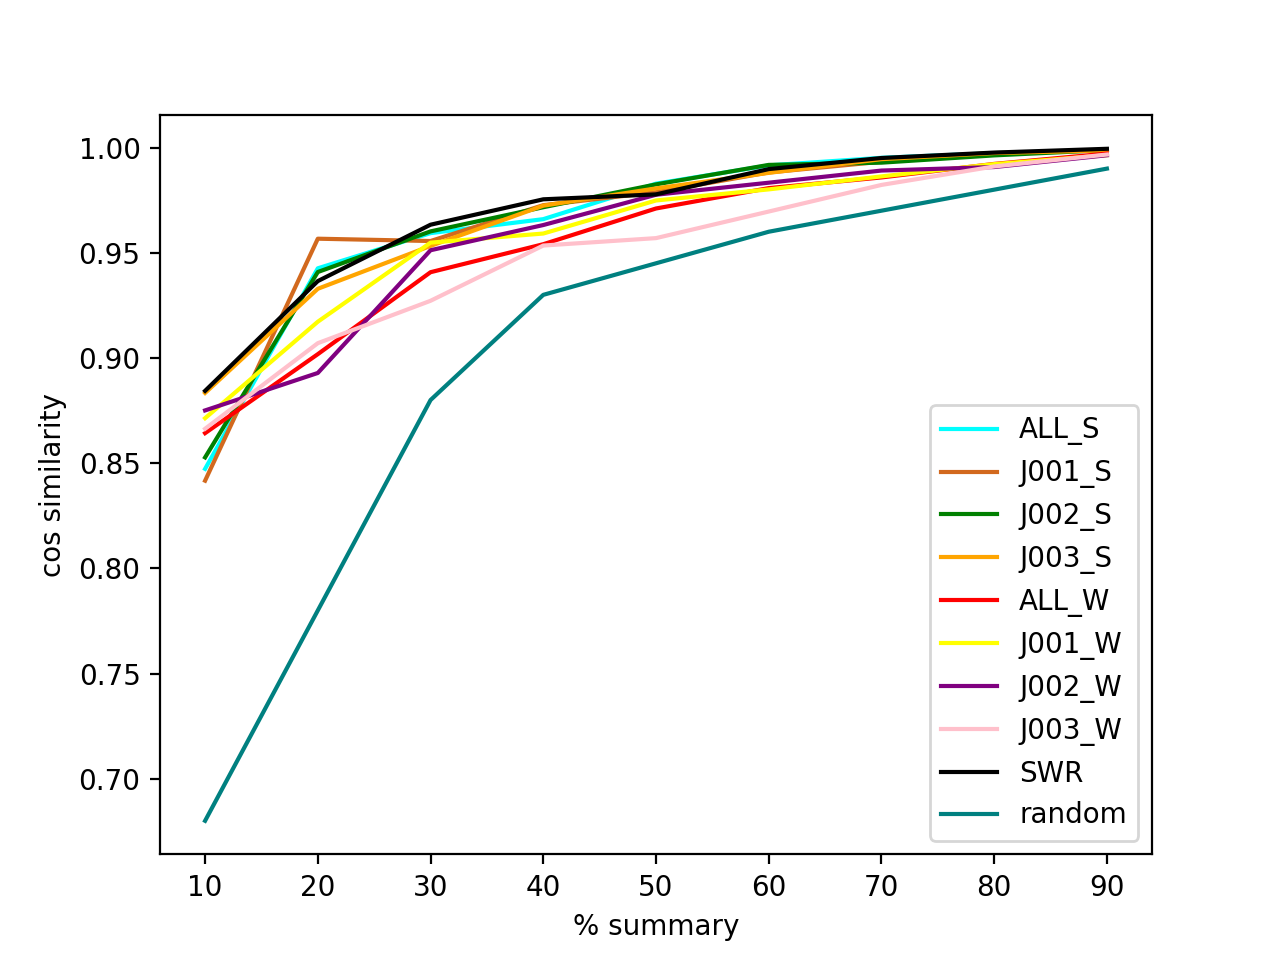

In [27]:
%matplotlib notebook
x=[10,20,30,40,50,60,70,80,90]
plt.figure()
plt.plot(x, y0show[1:], label ="ALL_S", color="#00FFFF")
plt.plot(x, y1show[1:], label ="J001_S", color="#D2691E")
plt.plot(x, y2show[1:], label ="J002_S", color="#008000")
plt.plot(x, y3show[1:], label ="J003_S", color="#FFA500")
plt.plot(x, y4show[1:], label ="ALL_W", color="#FF0000")
plt.plot(x, y5show[1:], label ="J001_W", color="#FFFF00")
plt.plot(x, y6show[1:], label ="J002_W", color="#800080")
plt.plot(x, y7show[1:], label ="J003_W", color="#FFC0CB")
plt.plot(x, y8show[1:], label ="SWR", color="#000000")
plt.plot(x, random, label ="random", color="#008080")
plt.xlabel("% summary")
plt.ylabel("cos similarity")
plt.legend() 

In [1]:
# SWR的数据
def getSWR(dirName, ldamodel, dictionary):
    file_dirs = os.listdir(swr_path)
    file_dirs.sort()
    res=[]
    for i in file_dirs:
        if os.path.isdir(swr_path + i):
            files = os.listdir(swr_path + i)
            files.sort()
            temp = []
            for file in files:
                if str(file).find(dirName)==0:
                    f = open(swr_path + i + "/" + file)
                    text_content = ""
                    for line in f.readlines():
                        if line != "\n":
                            text_content = text_content + line
                    text_content = text_content.replace("\n", "")
                
                    tokenizer = RegexpTokenizer(r'\w+')

                    en_stop = get_stop_words('en')

                    p_stemmer = WordNetLemmatizer()

#                     summ_tokens = tokenizer.tokenize(text_content)
#                     summ_stopped_tokens = [i for i in summ_tokens if not i in en_stop]
#                     # stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
#                     summ_stemmed_tokens = [p_stemmer.lemmatize(i) for i in summ_stopped_tokens]
                    
                    stemmed_tokens = lemmatize_sentence(text_content)
    
                    for k in range(len(stemmed_tokens)):
                        for letter in stemmed_tokens[k]:
                            if letter in string.punctuation:
                                stemmed_tokens[k] = stemmed_tokens[k].replace(letter, "")
            
                    stop_words = set(stopwords.words('english'))
                    summ_stemmed_tokens = [j.lower() for j in stemmed_tokens if j != '' and j not in stop_words]

                    summ_bow = dictionary.doc2bow(summ_stemmed_tokens)      
                    temp.append(ldamodel.get_document_topics(bow=summ_bow))
            res.append(temp)
                    
    return res
                
        

In [16]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(tokennized_text)

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in tokennized_text]
    
# generate LDA model
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=20)

In [26]:
doc, all_raw_text_list, all_filenames = getDoc(all_path + "2/docsent")
result, summ_sent_count_list = getSum(all_path + "2/extract/", all_filenames[0], all_raw_text_list[0], dictionary, ldamodel)

In [28]:
print(len(summ_sent_count_list))
print(summ_sent_count_list)
summ_sent_count_allj_list = [] # 5% - 90%
for index, count in enumerate(summ_sent_count_list):
    if index%8 == 0:
        summ_sent_count_allj_list.append(count)
print(summ_sent_count_allj_list)
# 去掉5%
summ_sent_count_allj_list.pop(0)
print(summ_sent_count_allj_list)

80
[1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 3, 1, 1, 4, 4, 4, 4, 2, 3, 2, 2, 6, 6, 6, 6, 2, 5, 3, 3, 8, 8, 8, 8, 5, 7, 4, 4, 9, 9, 9, 9, 7, 9, 6, 6, 11, 11, 11, 11, 8, 10, 9, 8, 13, 13, 13, 13, 10, 12, 11, 10, 15, 15, 15, 15, 12, 14, 13, 13, 17, 17, 17, 17, 16, 15, 15, 14]
[1, 2, 4, 6, 8, 9, 11, 13, 15, 17]
[2, 4, 6, 8, 9, 11, 13, 15, 17]


In [31]:
print(len(all_raw_text_list[0]))
total_length = len(all_raw_text_list[0])

18


In [35]:
# 随机选句子
random_sent = random.sample(range(total_length), 18)

[15, 2, 13, 9, 6, 11, 12, 0, 17, 8, 16, 4, 14, 10, 7, 3, 5, 1]


In [38]:
for count in summ_sent_count_allj_list:
    random_sent = random.sample(range(total_length), count)
    print(random_sent)
    summ_random = ''
    for sent in random_sent:
        summ_random = summ_random + all_raw_text_list[0][sent]
    print(summ_random)
    
    tokenizer = RegexpTokenizer(r'\w+')

    en_stop = get_stop_words('en')

    p_stemmer = WordNetLemmatizer()

            
    stemmed_tokens = lemmatize_sentence(summ_random)
    
    for k in range(len(stemmed_tokens)):
        for letter in stemmed_tokens[k]:
            if letter in string.punctuation:
                stemmed_tokens[k] = stemmed_tokens[k].replace(letter, "")
            
    stop_words = set(stopwords.words('english'))
    summ_stemmed_tokens = [j.lower() for j in stemmed_tokens if j != '' and j not in stop_words]

            
            
    summ_bow = dictionary.doc2bow(summ_stemmed_tokens)      
    res = ldamodel.get_document_topics(bow=summ_bow)
    print(res)

[14, 10]
In London , Mr Tung looks forward to meeting with Prime Minister Tony Blair .He will call on ministers , parliamentarians and senior officials of the Japanese Government .
[(0, 0.011263241), (1, 0.8616831), (2, 0.01132535), (3, 0.011398866), (4, 0.1043294)]
[15, 9, 13, 6]
Mr Tung will be speaking at a number of functions in various destinations .Mr Tung will be in Tokyo from October 15 to 17 .He also hopes to meet with Belgian ministers .He will visit Washington and New York .
[(0, 0.06980325), (3, 0.9030366)]
[6, 0, 12, 7, 9, 15]
He will visit Washington and New York . Chief Executive to renew ties with our trading partners In Brussels , Mr Tung will call on the President of the European Commission , Mr Jacques Santer , and attend the Trade Development Council Annual Dinner in Europe .In Washington , Mr Tung looks forward to meeting with President Clinton .Mr Tung will be in Tokyo from October 15 to 17 .Mr Tung will be speaking at a number of functions in various destinations

In [19]:
# # document_topic: 文本的分布
# doc_bow = dictionary.doc2bow(doc[i])
# document_topic = ldamodel.get_document_topics(doc_bow)
        
# # 计算相似度
# document_topic_porb = document_topic
# document_topic_list = []
# for i in document_topic:
#     a, b = i
#     document_topic_list.append(a)

In [20]:
# 9个% -> 10篇文章 
# swrresult = getSWR("2__", ldamodel, dictionary)

In [2]:
def solve_swrresult(swrresult, k):
    res = []
#     print(swrresult)
    for i in swrresult:
        res.append(i[k])
    return res
        

In [11]:
# print(solve_swrresult(swrresult, 9))